In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import thermocepstrum as tc

In [2]:
def blockAverage(datastream, isplot=True, maxBlockSize=0):
    
	"""This program computes the block average of a potentially correlated timeseries "x", and 
	provides error bounds for the estimated mean <x>. 
	As input provide a vector or timeseries "x", and the largest block size.
	
	Check out writeup in the following blog posts for more:
	http://sachinashanbhag.blogspot.com/2013/08/block-averaging-estimating-uncertainty_14.html
	http://sachinashanbhag.blogspot.com/2013/08/block-averaging-estimating-uncertainty.html
	"""
 
	Nobs         = len(datastream)           # total number of observations in datastream
	minBlockSize = 1;                        # min: 1 observation/block
 
	if maxBlockSize == 0:
		maxBlockSize = int(Nobs/4);        # max: 4 blocs (otherwise can't calc variance)
  
	NumBlocks = maxBlockSize - minBlockSize   # total number of block sizes

	blockMean = np.zeros(NumBlocks)               # mean (expect to be "nearly" constant)
	blockVar  = np.zeros(NumBlocks)               # variance associated with each blockSize
	blockCtr  = 0
	
				#
				#  blockSize is # observations/block
				#  run them through all the possibilities
				#
 
	for blockSize in range(minBlockSize, maxBlockSize):

		Nblock    = int(Nobs/blockSize)               # total number of such blocks in datastream
		obsProp   = np.zeros(Nblock)                  # container for parcelling block 

		# Loop to chop datastream into blocks
		# and take average
		for i in range(1,Nblock+1):
			
			ibeg = (i-1) * blockSize
			iend =  ibeg + blockSize
			obsProp[i-1] = np.mean(datastream[ibeg:iend])

		blockMean[blockCtr] = np.mean(obsProp)
		blockVar[blockCtr]  = np.var(obsProp)/(Nblock - 1)
		blockCtr += 1
 
	v = np.arange(minBlockSize,maxBlockSize)
 
	if isplot:

		fig, ax = plt.subplots(2, figsize=(6.0,3.0), constrained_layout=False)
		ax[0].plot(v, np.sqrt(blockVar),'ro-',lw=2)
		ax[0].set_xlabel('block size')
		ax[0].set_ylabel('std')

		#plt.subplot(2,1,2)
		ax[1].errorbar(v, blockMean, np.sqrt(blockVar))
		ax[1].set_ylabel('<x>')
		ax[1].set_xlabel('block size')

		print("<x> = {0:f} +/- {1:f}\n".format(blockMean[-1], np.sqrt(blockVar[-1])))

		plt.tight_layout()
		plt.show()
		
	return v, blockVar, blockMean

# STRESS ANALYSIS

In [3]:
Tmean = np.mean(np.loadtxt('ab_initio/125/400K/water125_300ok1.evp')[:,4])

In [4]:
stressok=[]
with open("ab_initio/125/400K/water125_300ok1.str") as fp1:
    for i, line in enumerate(fp1):
        if i%4 == 0:
            j=0
        else:
            j+= 1
        if j==1:
            a=line.split()
        elif j==2:
            b=line.split()
            stressok.append([float(a[1]),float(a[2]),float(b[2])])
stress=np.asarray(stressok,dtype=float)

In [5]:
jen_cp = stress[0:,:]

print('Tmean',Tmean)

nnvol_cp = 29.322033581614075**3
nndt_cp= 2 * 3.0 * 2.4189e-2

print('length of the traj',nndt_cp * np.size(jen_cp,0),' fs')

Tmean 409.793265604994
length of the traj 216934.25707799997  fs


In [32]:
# Crea l'oggetto HeatCurrent
nnjen_cp=tc.HeatCurrent(jen_cp,units='CP_vis',DT_FS=nndt_cp,TEMPERATURE=Tmean,VOLUME=nnvol_cp,PSD_FILTER_W=0.10)
rj_cp=nnjen_cp.resample_current(fstar_THz=12,plot=False,PSD_FILTER_W=0.10)
nnjen_cp.cepstral_analysis(Kmin_corrfactor=1)
rj_cp.cepstral_analysis(Kmin_corrfactor=1)

Using single component code.
trajectory has an odd number of points. Removing the first one.
Using single component code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =    3445.09212 THz
 Resampling freq          f* =      12.00381 THz
 Sampling time         TSKIP =           287 steps
                             =        41.653 fs
 Original  n. of frequencies =        747359
 Resampled n. of frequencies =          2605
 PSD      @cutoff  (pre-filter) =      0.21184
                  (post-filter) =      0.16738
 log(PSD) @cutoff  (pre-filter) =     -1.61279
                  (post-filter) =     -1.92483
 min(PSD)          (pre-filter) =      0.00000
 min(PSD)         (post-filter) =      0.01046
 % of original PSD Power f<f* (pre-filter)  = 18.552001
-----------------------------------------------------

-----------------------------------------------------
  CEPSTRAL AN

<IPython.core.display.Javascript object>


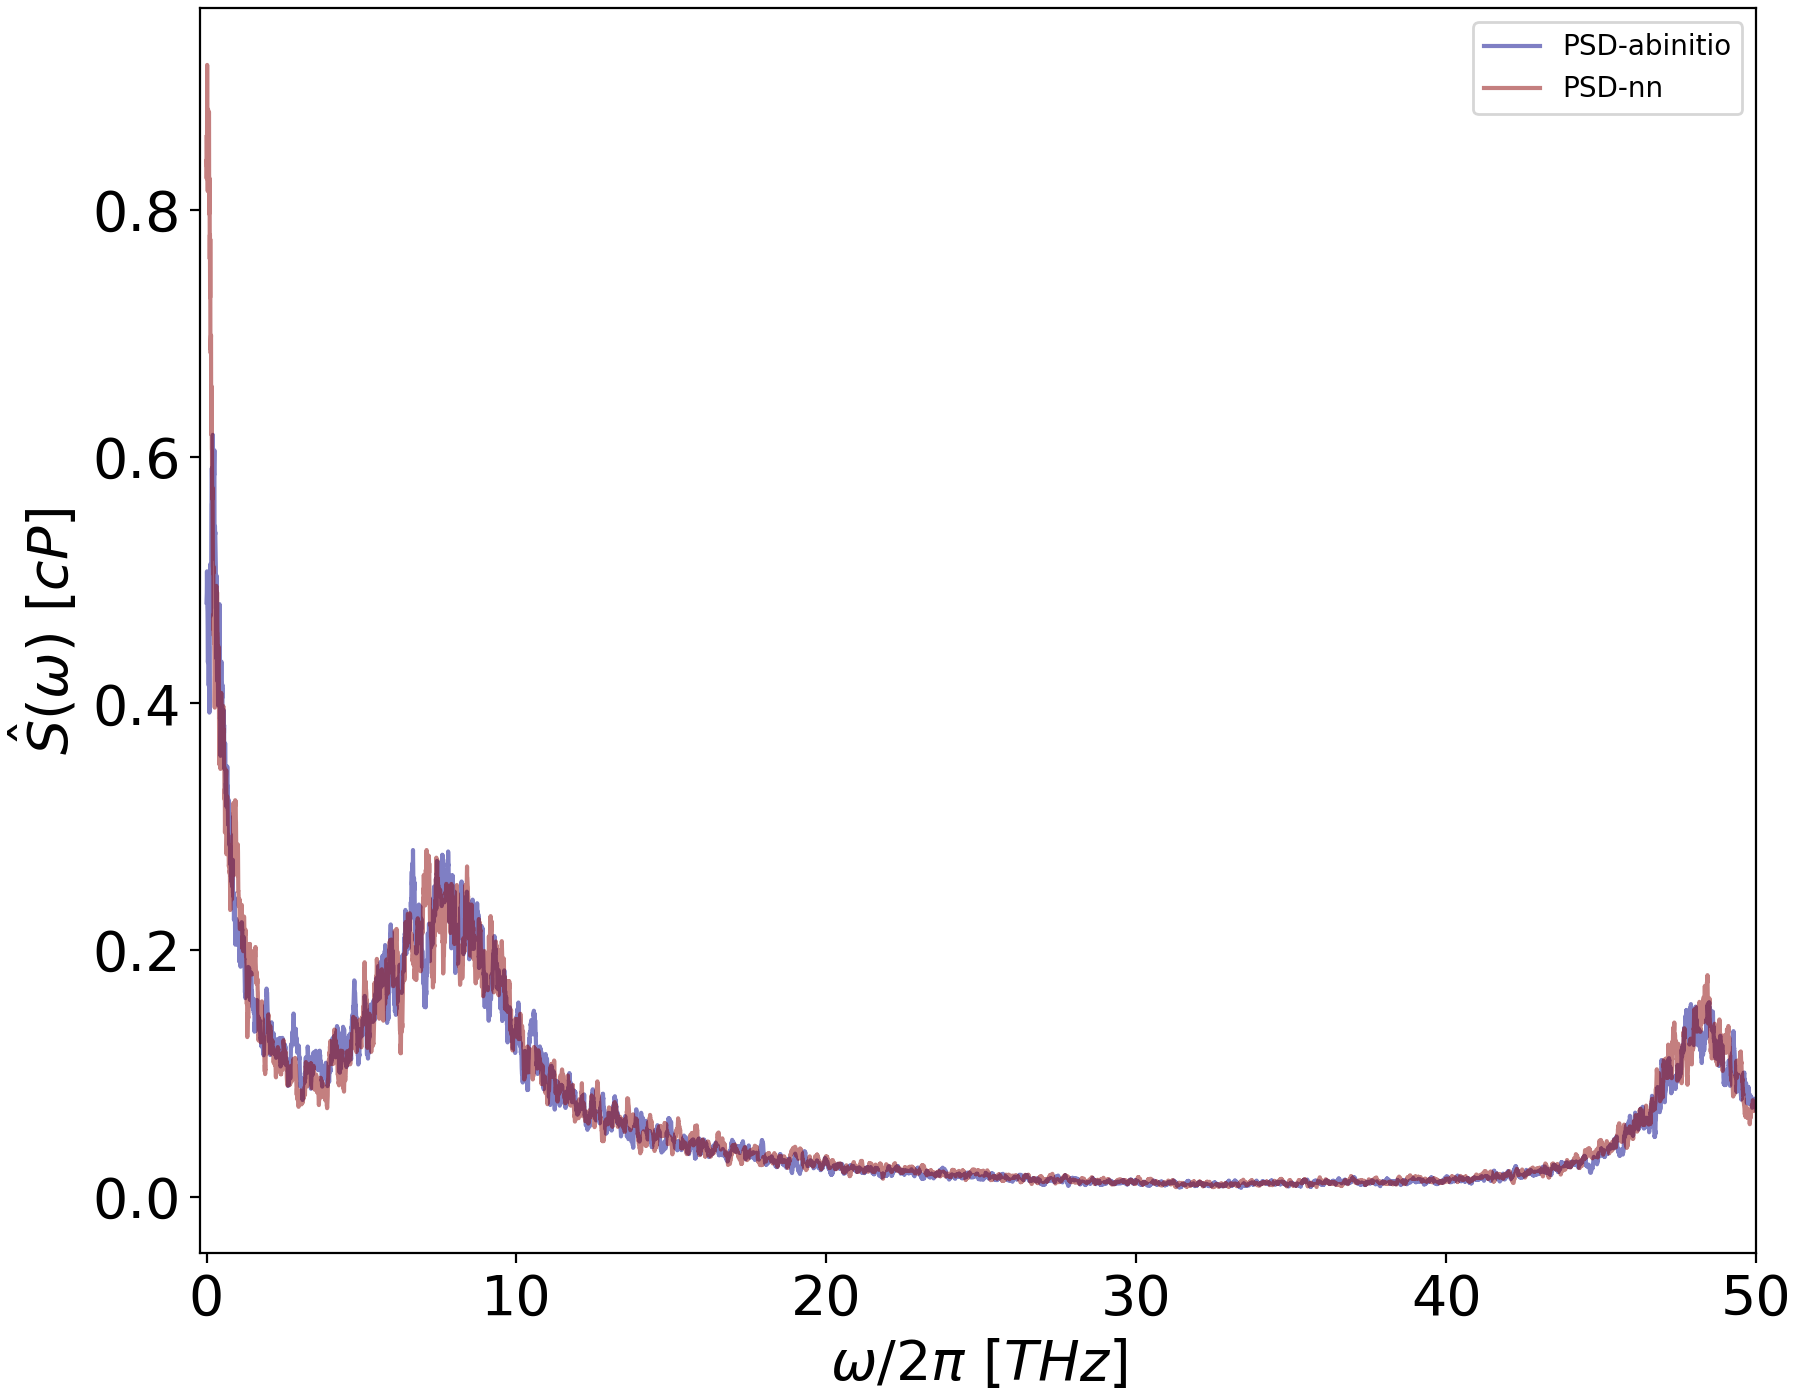

In [36]:
%matplotlib notebook

fig,ax = plt.subplots(1, figsize=(9.0,7.0), constrained_layout=True)
ls=20
# 
ax.tick_params(axis='x', labelsize=ls)
ax.tick_params(axis='y', labelsize=ls)
ax.set_xlabel(r'$\omega/2\pi \ [THz]$',fontsize=ls)
ax.set_ylabel(r'$\hat{S}(\omega) \ [cP]$',fontsize=ls)

j=nnjen_cp
jn = nnjen[410]
conv=j.kappa_scale/2*100
convn=jn.kappa_scale/2*100
ax.set_xlim((-0.2,50))
#ax.set_ylim((-0.02,2))


ax.plot(j.freqs_THz, j.fpsd*conv, label='PSD-abinitio',alpha=0.5, color='darkblue', rasterized=True)
ax.plot(jn.freqs_THz, jn.fpsd*convn, label='PSD-nn',alpha=0.5, color='darkred', rasterized=True)

ax.legend()

TSKIP =  3445
Using single component code.
-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 1  (P* = 2, corr_factor = 1.000000)
  L_0*   =           0.066149 +/-   0.074062
  S_0*   =           1.545155 +/-   0.114437
-----------------------------------------------------
  kappa* =           0.005101 +/-   0.000378  W/mK
-----------------------------------------------------

TSKIP =  1148
Using single component code.
-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 3  (P* = 4, corr_factor = 1.000000)
  L_0*   =           0.046921 +/-   0.065166
  S_0*   =           1.515728 +/-   0.098774
-----------------------------------------------------
  kappa* =           0.005004 +/-   0.000326  W/mK
-----------------------------------------------------

TSKIP =  689
Using single component code.
----------------

Using single component code.
-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 34  (P* = 35, corr_factor = 1.000000)
  L_0*   =           0.017825 +/-   0.058233
  S_0*   =           1.472261 +/-   0.085734
-----------------------------------------------------
  kappa* =           0.004861 +/-   0.000283  W/mK
-----------------------------------------------------

TSKIP =  88
Using single component code.
-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 29  (P* = 30, corr_factor = 1.000000)
  L_0*   =          -0.057334 +/-   0.052382
  S_0*   =           1.365664 +/-   0.071536
-----------------------------------------------------
  kappa* =           0.004509 +/-   0.000236  W/mK
-----------------------------------------------------

TSKIP =  84
Using single component code.
-----------------------------

<IPython.core.display.Javascript object>


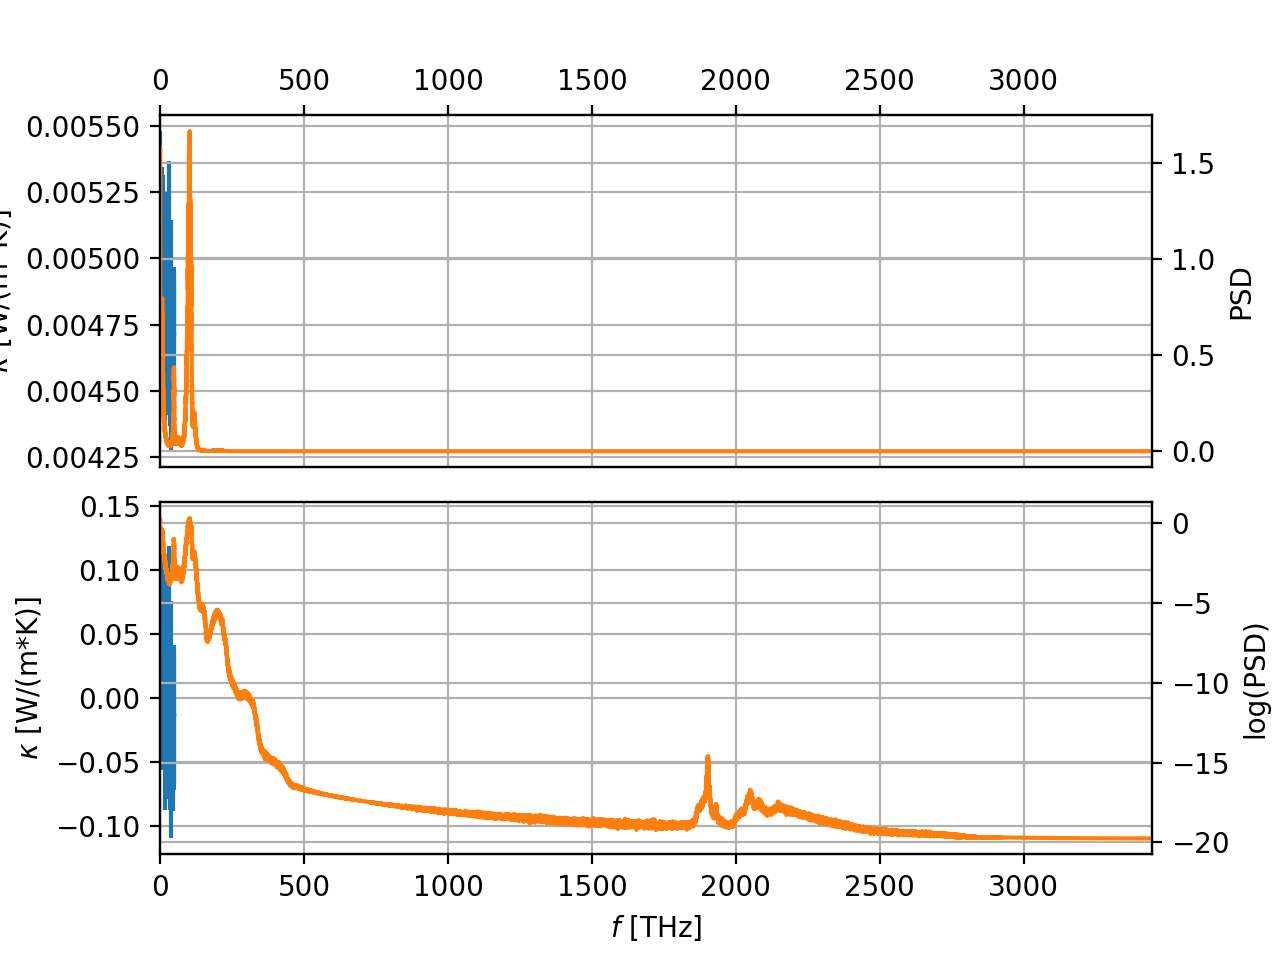

In [8]:
jjjen_cp ={}
corrfactors = np.arange(1,2)
for cor in corrfactors:
    TSKIP_LIST_cp = np.array([nnjen_cp.Nyquist_f_THz/j for j in range(1,50,2)],dtype=np.int)
    jjjen_cp[cor],ax,f = tc.heatcurrent.fstar_analysis(nnjen_cp, TSKIP_LIST_cp, Kmin_corrfactor=cor)

In [ ]:
%matplotlib notebook


fig,ax= plt.subplots(1, figsize=(9.0,7.0), constrained_layout=True)
ls=15
# 
ax.tick_params(axis='x', labelsize=ls)
ax.tick_params(axis='y', labelsize=ls)
kappa_Kmin={}
kappa_Kmin_err={}
ax.set_xlim((0,140))
ax.set_ylim((0.350,0.7))
for cor in corrfactors:
    FSTAR_LIST_cp = np.array([j.Nyquist_f_THz for j in jjjen_cp[cor]])
    kappa_Kmin[cor] = np.array([j.kappa_Kmin*100 for j in jjjen_cp[cor]])
    kappa_Kmin_err[cor] = np.array([j.kappa_Kmin_std*100 for j in jjjen_cp[cor]])
    f1=ax.plot(FSTAR_LIST_cp, kappa_Kmin[cor],'-o',color='black')
    ax.fill_between(FSTAR_LIST_cp, kappa_Kmin[cor]-kappa_Kmin_err[cor],kappa_Kmin[cor]+kappa_Kmin_err[cor],alpha=0.7,color='dodgerblue')

ax.set_xlabel(r'$f^*$ $(THz)$',fontsize=ls)
ax.set_ylabel(r'$\eta$ $(cP)$',fontsize=ls)
ax.set_xlim((FSTAR_LIST[0],FSTAR_LIST[-1]))
#plt.savefig('/Users/cesaremalosso/Documents/university/sissa/thesis/plot/ab_initio/f_starP_star.pdf')

In [45]:
data={}
temp_list=[410]

In [46]:
for t in temp_list:
    lista=[]
    for i in range(2,4):
        lista.append(np.loadtxt('2mln_train-old/'+str(t)+'K_3/stress'+str(i)+'.0.4fs.out',skiprows=1))    
    data[t]=np.concatenate((lista))

In [47]:
tmean={}
for t in temp_list:
    
    tmean[t]=np.mean(data[t][:,2])
    print('<T> = {:.3f} +- {:.3f}'.format(tmean[t],np.std(data[t][:,2])))

<T> = 416.381 +- 14.659


In [48]:
nndt_fs=0.4
nnvol=1.5516553065000000e+01**3

nnjen={}
rj={}
for t in temp_list:
    nnjen[t]=tc.HeatCurrent(data[t][:,3:],units='metal_vis',DT_FS=nndt_fs,TEMPERATURE=tmean[t],VOLUME=nnvol,PSD_FILTER_W=0.10)
    rj[t]=nnjen[t].resample_current(fstar_THz=8,plot=False,PSD_FILTER_W=0.10)
    nnjen[t].cepstral_analysis(Kmin_corrfactor=1)
    rj[t].cepstral_analysis(Kmin_corrfactor=1)

Using single component code.
Using single component code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =    1250.00000 THz
 Resampling freq          f* =       8.01282 THz
 Sampling time         TSKIP =           156 steps
                             =        62.400 fs
 Original  n. of frequencies =        250001
 Resampled n. of frequencies =          1603
 PSD      @cutoff  (pre-filter) = 68669904.90996
                  (post-filter) = 52670168.49736
 log(PSD) @cutoff  (pre-filter) =     17.92608
                  (post-filter) =     17.63012
 min(PSD)          (pre-filter) =      3.90153
 min(PSD)         (post-filter) = 448718.65332
 % of original PSD Power f<f* (pre-filter)  = 12.942328
-----------------------------------------------------

-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------

In [ ]:
for t in temp_list:
    print('temp={:.0f} : eta = {:.4f} +- {:.4f} cP'.format(tmean[t],rj[t].kappa_Kmin*100,rj[t].kappa_Kmin_std*100))

In [ ]:
%matplotlib notebook

fig,ax = plt.subplots(1, figsize=(9.0,7.0), constrained_layout=True)
ls=18
# 
ax.tick_params(axis='x', labelsize=ls)
ax.tick_params(axis='y', labelsize=ls)
ax.tick_params(axis='x', labelsize=ls)
ax.set_xlabel(r'$\omega/2\pi \ (THz)$',fontsize=ls)
ax.set_ylabel(r'${^l}\hat{S}_{k} \ (cP)$',fontsize=ls)

t=410
j=nnjen[t]
fj=rj[t]
conv=j.kappa_scale/2*100
ax.set_xlim((-0.2,20))
ax.set_ylim((-0.02,2))


ax.plot(j.freqs_THz, j.psd*conv, label='PSD',alpha=0.9, color='silver')
ax.plot(j.freqs_THz, j.fpsd*conv, label='PSD wind filter = 0.1 THz',alpha=0.7, color='dodgerblue')
ax.plot(fj.freqs_THz, fj.dct.psd*conv, label='cepstro re-sampled', color='red')
#ax.plot(j.freqs_THz, j.dct.psd*conv, label='cepstro', color='black')



TSKIP =  1250
Using single component code.
-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 1  (P* = 2, corr_factor = 1.000000)
  L_0*   =          18.517949 +/-   0.076968
  S_0*   =   159399416.418788 +/- 12268590.060250
-----------------------------------------------------
  kappa* =           0.005179 +/-   0.000399  W/mK
-----------------------------------------------------

TSKIP =  416
Using single component code.
-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 3  (P* = 4, corr_factor = 1.000000)
  L_0*   =          18.455101 +/-   0.067879
  S_0*   =   149689932.683364 +/- 10160808.974420
-----------------------------------------------------
  kappa* =           0.004864 +/-   0.000330  W/mK
-----------------------------------------------------

TSKIP =  250
Using single component code.
-------

Using single component code.
-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 31  (P* = 32, corr_factor = 1.000000)
  L_0*   =          18.394568 +/-   0.057311
  S_0*   =   140897480.318549 +/- 8075036.266411
-----------------------------------------------------
  kappa* =           0.004578 +/-   0.000262  W/mK
-----------------------------------------------------

TSKIP =  32
Using single component code.
-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 33  (P* = 34, corr_factor = 1.000000)
  L_0*   =          18.402120 +/-   0.058199
  S_0*   =   141965612.544809 +/- 8262314.904920
-----------------------------------------------------
  kappa* =           0.004613 +/-   0.000268  W/mK
-----------------------------------------------------

TSKIP =  30
Using single component code.
---------------------

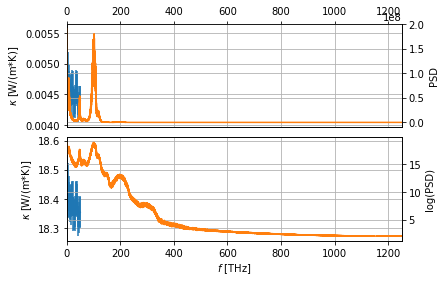

In [51]:
t=410
jjjen_nn ={}
corrfactors = np.arange(1,2)
for cor in corrfactors:
    TSKIP_LIST_nn = np.array([nnjen[t].Nyquist_f_THz/j for j in range(1,50,2)],dtype=np.int)
    jjjen_nn[cor],ax,f = tc.heatcurrent.fstar_analysis(nnjen[t], TSKIP_LIST_nn, Kmin_corrfactor=cor)




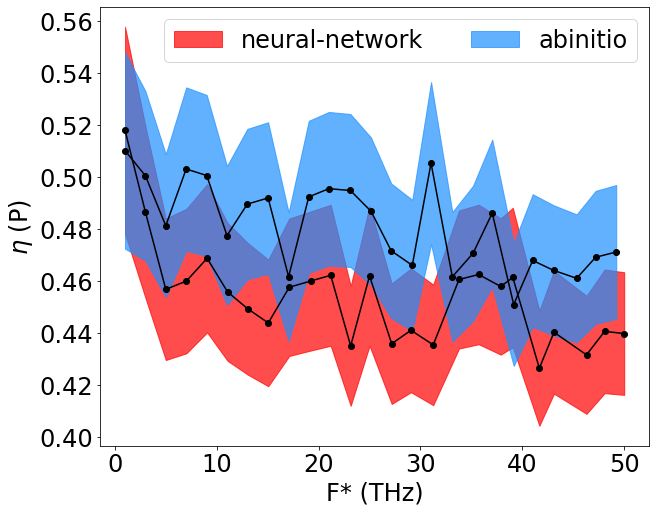

In [52]:
%matplotlib inline


fix,ax = plt.subplots(1, figsize=(9.0,7.0), constrained_layout=True)
ls=24
# 
ax.tick_params(axis='x', labelsize=ls)
ax.tick_params(axis='y', labelsize=ls)
kappa_Kmin={}
kappa_Kmin_err={}

for cor in corrfactors:
    FSTAR_LIST_nn = np.array([j.Nyquist_f_THz for j in jjjen_nn[cor]])
    kappa_Kmin[cor] = np.array([j.kappa_Kmin*100 for j in jjjen_nn[cor]])
    kappa_Kmin_err[cor] = np.array([j.kappa_Kmin_std*100 for j in jjjen_nn[cor]])
    f1=ax.plot(FSTAR_LIST_nn, kappa_Kmin[cor],'-o',color='black')
    ax.fill_between(FSTAR_LIST_nn, kappa_Kmin[cor]-kappa_Kmin_err[cor],kappa_Kmin[cor]+kappa_Kmin_err[cor],alpha=0.7, color='red',label='neural-network')

for cor in corrfactors:
    FSTAR_LIST_cp = np.array([j.Nyquist_f_THz for j in jjjen_cp[cor]])
    kappa_Kmin[cor] = np.array([j.kappa_Kmin*100 for j in jjjen_cp[cor]])
    kappa_Kmin_err[cor] = np.array([j.kappa_Kmin_std*100 for j in jjjen_cp[cor]])
    f1=ax.plot(FSTAR_LIST_cp, kappa_Kmin[cor],'-o',color='black')
    ax.fill_between(FSTAR_LIST_cp, kappa_Kmin[cor]-kappa_Kmin_err[cor],kappa_Kmin[cor]+kappa_Kmin_err[cor],alpha=0.7,color='dodgerblue',label='abinitio')

#plt.savefig('/Users/cesaremalosso/Documents/university/sissa/thesis/plot/ab_initio/f_starP_star.pdf')
ax.set_xlabel('F* (THz)',fontsize=ls)
ax.set_ylabel(r'$\eta$ (P)',fontsize=ls)
ax.legend(fontsize=ls,ncol=3)

In [53]:
print(1268.05477588/20)
print(1268.12343347/20)
print(1268.14328318/20)
print(1268.16110926/20)
print(1268.16372889/20)
print(1268.16440588/20)

63.402738794
63.4061716735
63.407164159000004
63.408055463000004
63.4081864445
63.408220294


In [54]:
print(1268.16110972/20)
print(1268.15201842/20)
print(1268.15161365/20)
print(1268.15100190/20)

63.408055486
63.407600921000004
63.4075806825
63.407550095


In [55]:
print(-341.43936215/8)
print(-341.51591289/8)
print(-341.52389041/8)
print(-341.53094351/8)
print(-341.53163163/8)
print(-341.53227518/8)
print(-341.53258019/8)
print(-341.53268766/8)
print(-341.53285944/8)

-42.67992026875
-42.68948911125
-42.69048630125
-42.69136793875
-42.69145395375
-42.6915343975
-42.69157252375
-42.6915859575
-42.69160743
